In [1]:
import math 
import os
import re
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


from concurrent.futures import ThreadPoolExecutor
from os import listdir
from os.path import isfile, join
from random import sample
from scipy.spatial import distance
from scipy.cluster import hierarchy as hc
from scipy.linalg import sqrtm, block_diag, pinvh, eigh
from numpy.linalg import inv, pinv
from numpy.random import normal, poisson, randint
from numpy import diagflat, eye, fill_diagonal, diag, sqrt, min, max
from sklearn.utils import resample

from aux_functions import *
from utls import *

In [2]:
def process_graph(size):
    graph = genWG(d=size, p11=.8, p22=.7, p12=.3, lam11=20, lam22=15, lam12=6)
    return graph + np.ones((size, size))

# Experiments

In [3]:
#Generate data

d = 8 #matrix size
pop_size = 8000  # размер популяции


#Generate regularized adjacency matrices
population_graphs = [] 
with ThreadPoolExecutor() as executor:
    population_graphs = list(executor.map(lambda _: process_graph(size = d), range(pop_size)))
       

#Create projected and inverted GLs
population = [] 

U = GenONbasisVec(d) #ON basis for projection of GL
for p in population_graphs:
    population.append(genGLFast(p, U)) #compute and project GL

In [22]:
#Initiate resampling parameters
Ns = [10, 30, 100] #sample size
N = 1000  #number of iterations withn one bootstrap/asymptotic trial 
M = 100 #number of bootstrap/asymptotic curves

setting = 'real_'

In [23]:
all_data  = {'true': 0, 'boot': 0, 'asm': 0}
ecdfs = {'true': 0, 'boot': 0, 'asm': 0}
k_dist = {key: None for key in Ns}
x_grds = {key: None for key in Ns}
k_stat = {'boot': 0, 'asm': 0}
k_dist = {'boot': 0, 'asm': 0}

for key in all_data.keys():
    all_data[key] = {key: None for key in Ns}
    ecdfs[key] = {key: None for key in Ns}
    
    if key != 'true':
        k_stat[key] = {key: {'mean':None, 'var':None} for key in Ns}
        k_dist[key] = {key: None for key in Ns}


In [24]:
for key in all_data.keys():
    for n in Ns:
        if key == 'true':
            #True distribution
            dummy = true_distr(population, size = n, boot_samples=N, setting = setting)
        elif key == 'boot':
            dummy = bootstrap(population, size = n, iters = M, boot_samples = N, model = "Exponential", setting = setting)
        elif key == 'asm':
            dummy = asymptotic_statistics(population, size = n, iters = M, boot_samples = N, setting = setting)
        
        all_data[key][n] = dummy

1 0.13529889644690965
2 0.0020099621295416297
3 0.00013071095760667188
Success! Iterations number: 3
1 0.13529889644690965
2 0.0020099621295416297
3 0.00013071095760667188
Success! Iterations number: 3
1 0.13529889644690965
2 0.0020099621295416297
3 0.00013071095760667188
Success! Iterations number: 3


In [25]:
for n in Ns:
    x_grds[n] = find_grid(all_data['true'][n], all_data['boot'][n], all_data['asm'][n], steps = 500)

for key in all_data.keys():
    for n in Ns:
        if key == 'true':
            ecdfs[key][n] = ecdf_on_grid(all_data[key][n], x_grds[n])
        else:
            ecdfs[key][n] = ecdfs_on_grid(all_data[key][n], x_grds[n])
        
for n in Ns:
    for key in ['boot', 'asm']:
        k_dist[key][n] = compute_K_dist(all_data['true'][n], all_data[key][n])
        m_k, s_k = compute_K_stat(k_dist[key][n])
        k_stat[key][n]['mean'] =  ceil_to_decimals(m_k, 3)
        k_stat[key][n]['var']  =  ceil_to_decimals(s_k, 3)

In [26]:
# for j in range(len(Ns)):
#     x_grd = find_grid(true_all[j], boot_all[j], asm_all[j], steps = 500)
#     x_all.append(x_grd)

#     ecdf_true   = ecdf_on_grid(true_all[j], x_grd)
#     ecdfs_true_all.append(ecdf_true)  

#     ecdfs_boot  = compute_ecdfs(boot_all[j], x_grd)
#     ecdfs_boot_all.append(ecdfs_boot)

#     ecdfs_asymp = compute_ecdfs(asm_all[j], x_grd)
#     ecdfs_asm_all.append(ecdfs_asymp)

# m_boot, v_boot = compute_KS_stat(ecdf_true, ecdfs_boot)
# m_asmp, v_asmp = compute_KS_stat(ecdf_true, ecdfs_asymp)


# print(m_boot, v_boot)
# print(m_asmp, v_asmp) 

In [27]:
# KS_var_asm = ceil_to_decimals(v_asmp , 3)
# KS_mean_asm = ceil_to_decimals(m_asmp, 3)
# KS_var_boot = ceil_to_decimals(v_boot, 3)  
# KS_mean_boot = ceil_to_decimals(m_boot, 3)  

# Plots

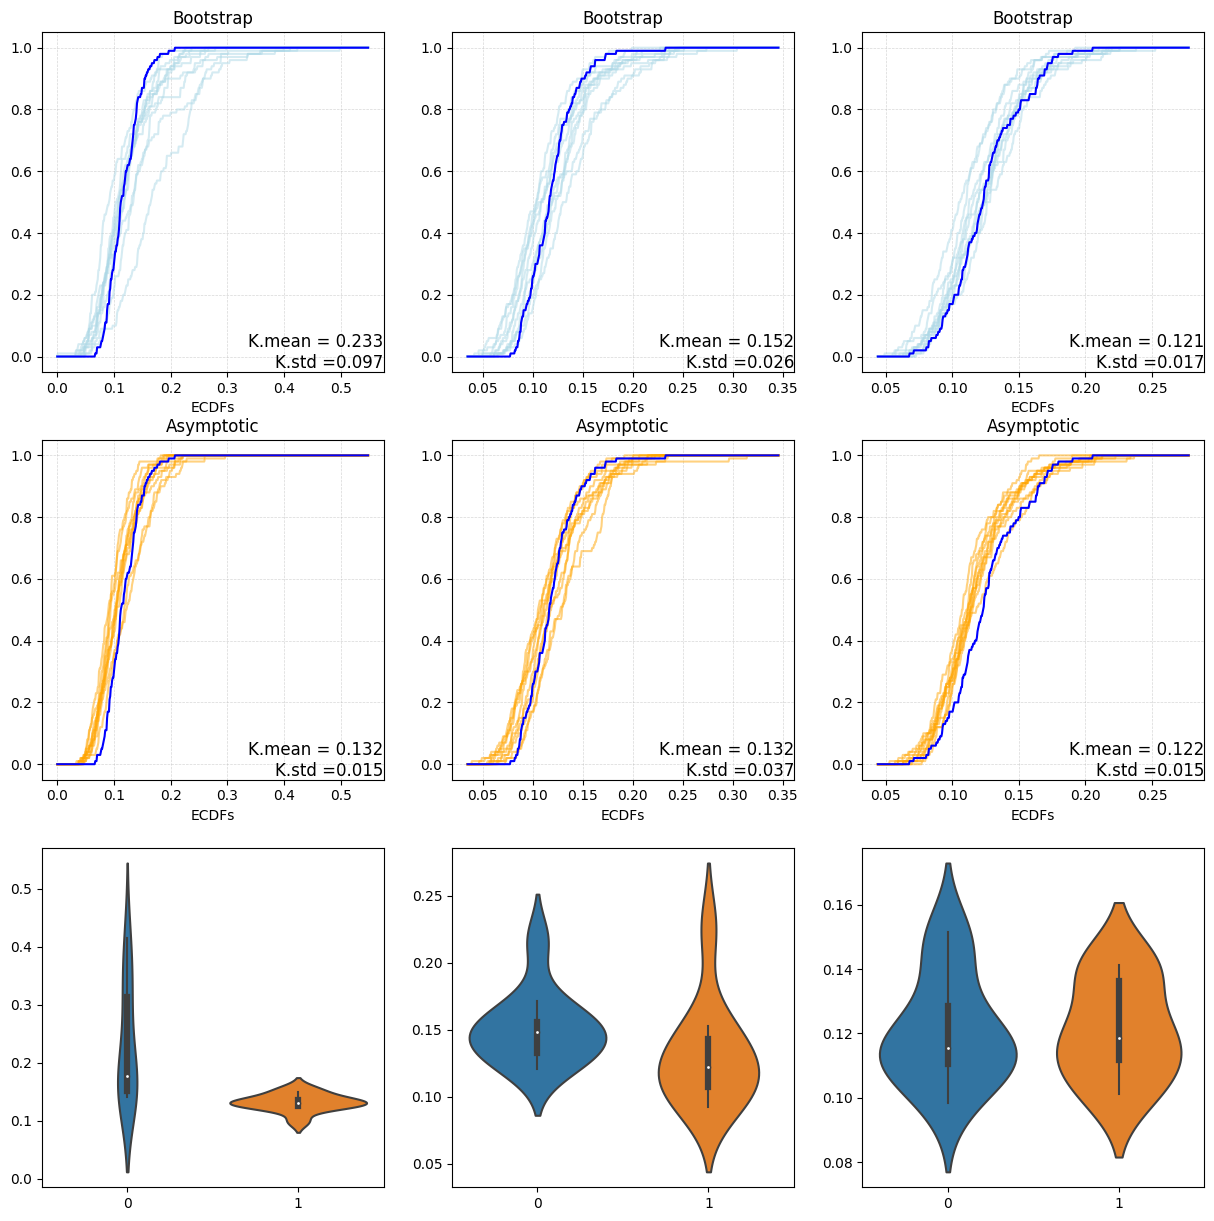

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
l = 0

for key in ['boot', 'asm', 'dummy']:
    if key == 'boot':
        lbl = 'boot.'
        l = 0
        col = 'lightblue'
        tlt = 'Bootstrap'
    elif key == 'asm':
        lbl = 'asymp.'
        l = 1
        col = 'orange'
        tlt = 'Asymptotic'
    elif key == 'dummy':
        l = 2

    for j in range(len(Ns)):
        ax = axes[l, j]
        key_n = Ns[j]
        if key != 'dummy':

            for r in range(M):  
                if (r == 1):
                    ax.plot(x_grds[key_n], ecdfs[key][key_n][r], c=col, alpha = .5, label=lbl)
                else:
                    ax.plot(x_grds[key_n], ecdfs[key][key_n][r], c=col, alpha = .5, label=lbl)


            ax.plot(x_grds[key_n], ecdfs['true'][key_n], c = 'blue', label='true', lw = 1.5)
            ax.set_title(tlt)
            ax.set_xlabel("ECDFs")
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Add pale grid
            xlim1 = ax.get_xlim()
            ylim1 = ax.get_ylim()
            ax.text(xlim1[1], ylim1[0], "K.mean = {0}\nK.std ={1}".format(k_stat[key][key_n]['mean'],k_stat[key][key_n]['var']), fontsize=12, color='black', 
             ha='right', va='bottom')
            
        elif key == 'dummy':
            sns.violinplot(data=[k_dist['boot'][key_n], k_dist['asm'][key_n]], ax=ax)




plt.savefig("Ecdfs_d={0}_L_proj.png".format(d), dpi=300)

In [29]:
key

'dummy'

NameError: name 'ecdfs_boot' is not defined

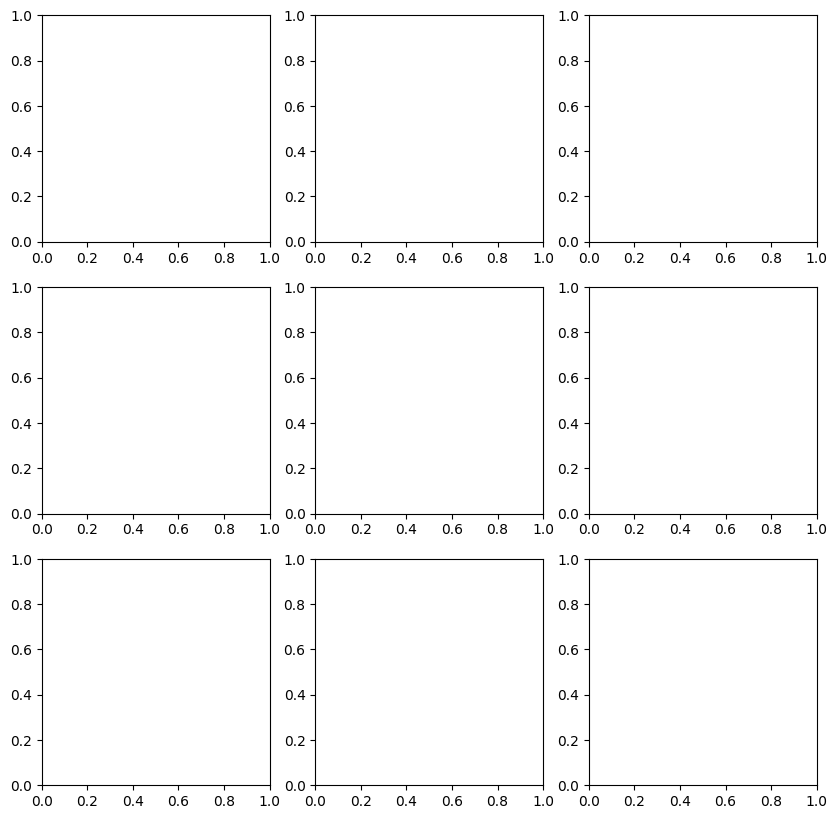

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))


for i in range(len(ecdfs_boot)):  
    if (i == 1):
        axes[0].plot(x_grd, ecdfs_boot[i], c='lightblue', alpha = .5, label='bootstrap')
    else:
        axes[0].plot(x_grd, ecdfs_boot[i], c = 'lightblue', alpha = .5)
        

axes[0].plot(x_grd, ecdf_true, c = 'blue', label='true', lw = 1.5)

axes[0].set_title("Bootstrap")
axes[0].set_xlabel("ECDFs")
# axes[0].set_ylabel("sin(x)")
axes[0].legend(loc='best')
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Add pale grid
xlim1 = axes[0].get_xlim()
ylim1 = axes[0].get_ylim()

# Place text in the lower-right corner of the first plot
axes[0].text(xlim1[1], ylim1[0], "KS.mean = {0}\nKS.var ={1}".format(KS_mean_boot, KS_var_boot), fontsize=12, color='black', 
             ha='right', va='bottom')


for i in range(len(ecdfs_asymp)):  
    if (i == len(ecdfs_asymp) - 1):
        axes[1].plot(x_grd, ecdfs_asymp[i], c='orange', alpha = .5, label='asymp.')
    else:
        axes[1].plot(x_grd, ecdfs_asymp[i], c = 'orange', alpha = .5)

axes[1].plot(x_grd, ecdf_true, c = 'blue', label='true', lw = 1.5)
axes[1].set_title("Asymptotic")
axes[1].set_xlabel("ECDFs")
# axes[0].set_ylabel("sin(x)")
axes[1].legend(loc='best')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Add pale grid

# Place text in the lower-right corner of the first plot
axes[1].text(xlim1[1], ylim1[0], "KS.mean = {0}\nKS.var ={1}".format(KS_mean_asm, KS_var_asm), fontsize=12, color='black', 
             ha='right', va='bottom')



fig.suptitle("d = {0}, n = {1}".format(d, n), fontsize=16)

plt.savefig("boot_cdfs_d={0}_n={1}_L_proj.png".format(d, n), dpi=300)